# Plotting functions for Heisenberg XY model

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit

In [3]:
def load_data(filepath):
    """Loads data from a pickle file."""
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    return data

In [4]:
def plot_phase_diagrams(data, filename_prefix="", output_dir="plots"):
    """Plots phase diagrams for ground-state energy, spectral gap, and mid-chain entropy."""
    L = data["system_size"]
    gammas = data["gamma_vals"]
    Js = data["J_vals"]
    E0 = data["E0"]
    gap = data["gap"]
    SvN = data["SvN"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Phase Diagrams for L={L}", fontsize=16)

    titles = [r'Ground-state energy density $e_0$',
              r'Spectral gap $\Delta$',
              r'Mid-chain entropy $S_{\mathrm{vN}}$']
    plot_data = [E0 / L, gap, SvN]

    for ax, dat, title in zip(axes, plot_data, titles):
        im = ax.imshow(dat,
                       origin='lower',
                       extent=[gammas[0], gammas[-1],
                               Js[0], Js[-1]],
                       aspect='auto',
                       cmap='viridis')
        ax.set_title(title, fontsize=13)
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'$J$')
        fig.colorbar(im, ax=ax, fraction=0.046)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Ensure output_dir exists
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"{filename_prefix}_L{L}_phase_diagrams.png")
    plt.savefig(plot_filename)
    print(f"Saved phase diagram: {plot_filename}")
    plt.show() # Show plot in notebook

In [202]:
def plot_entropy_vs_L(entropy_data_dict, target_J, target_gamma, x_log_scale=False, output_dir=".", filename_prefix=""):
    """Plots mid-chain entropy vs. system size (L) for fixed J and gamma.
    entropy_data_dict: dict where keys are L and values are entropy for that L.
    """
    if not entropy_data_dict:
        print("No entropy data provided for L-dependency plot.")
        return

    # Sort by L before plotting
    sorted_L_values = np.array(sorted(entropy_data_dict.keys()))
    entropies_for_plot = [entropy_data_dict[l_val] for l_val in sorted_L_values]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.plot(sorted_L_values, entropies_for_plot, marker='o', label='data')
    ax2.plot(sorted_L_values, entropies_for_plot, marker='o', label='data')
    ax3.plot(sorted_L_values, entropies_for_plot, marker='o', label='data')

    def log_fit1(L, a, b):
        return a * np.log2(2*L/np.pi * np.sin(np.pi/2 * (L//2)/L)) + b

    def log_fit2(L, a, b, c):
        return a * np.log2(2*L/np.pi * np.sin(np.pi/2 * (L//2)/L)) + b + c / L**2

    def log_fit3(L, a, b, c, d):
        return a * np.log2(2*L/np.pi * np.sin(np.pi/2 * (L//2)/L)) + b + c / L**2 + d * (-1)**(L//2) / L**2

    # Fit the data to the log function
    popt, pcov = curve_fit(log_fit1, sorted_L_values, entropies_for_plot)
    a, b, *_ = popt
    a_std, b_std = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])

    ax1.set_title("Fisher-Hartwig")
    # Plot the fit
    ax1.plot(sorted_L_values, log_fit1(sorted_L_values, *popt), 'r-', label=fr'Fit: $({a:.2f}\pm {a_std:.2f}) \log_2\left(\frac{{2L}}{{\pi}} \sin\frac{{\pi\ell}}{{2L}} \right) + ({b:.2f}\pm {b_std:.2f})$')

    ax1.plot(sorted_L_values, log_fit1(sorted_L_values, 1/12, *popt[1:]), 'b--', label=r'$\frac{1}{12} \log_2\left(\frac{{2L}}{{\pi}}\right) + k$')

    # Fit the data to the log function
    popt, pcov = curve_fit(log_fit2, sorted_L_values, entropies_for_plot)
    a, b, c = popt
    a_std, b_std = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])

    ax2.set_title("$L^{-2}$ correction")
    # Plot the fit
    ax2.plot(sorted_L_values, log_fit2(sorted_L_values, *popt), 'r-', label=fr'Fit: $({a:.2f}\pm {a_std:.2f}) \log_2\left(\frac{{2L}}{{\pi}} \sin\frac{{\pi\ell}}{{2L}} \right) + ({b:.2f}\pm {b_std:.2f}) + ({c:.2f})L^{{-2}}$')

    ax2.plot(sorted_L_values, log_fit2(sorted_L_values, 1/12, *popt[1:]), 'b--', label=r'$\frac{1}{12} \log_2\left(\frac{{2L}}{{\pi}} \sin\frac{{\pi\ell}}{{2L}} \right) + k + \mathcal{O}(L^{-2})$')


    # Fit the data to the log function
    popt, pcov = curve_fit(log_fit3, sorted_L_values, entropies_for_plot)
    a, b, c, d = popt
    a_std, b_std = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])

    ax3.set_title("even-odd oscillation")
    # Plot the fit
    ax3.plot(sorted_L_values, log_fit3(sorted_L_values, *popt), 'r-', label=fr'Fit: $({a:.2f}\pm {a_std:.2f}) \log_2\left(\frac{{2L}}{{\pi}} \sin\frac{{\pi\ell}}{{2L}} \right) + ({b:.2f}\pm {b_std:.2f}) + ({c:.2f})L^{{-2}} + (-1)^\ell ({d:.2f}) L^{{-2}} $')

    ax3.plot(sorted_L_values, log_fit3(sorted_L_values, 1/12, *popt[1:]), 'b--', label=r'$\frac{1}{12} \log_2\left(\frac{{2L}}{{\pi}} \sin\frac{{\pi\ell}}{{2L}} \right) + k + \mathcal{O}(L^{-2}) + (-1)^{\ell}\mathcal{O}(L^{-2})$')



    # plt.plot(sorted_L_values, np.abs(log_fit(sorted_L_values, 1/12, *popt[1:]) - log_fit(sorted_L_values, *popt)))
    if x_log_scale:
        for ax in fig.axes:
            ax.set_xscale('log')

    fig.suptitle(fr'Mid-chain Entropy vs. System Size (L) (J={target_J:.2f}, $\gamma$={target_gamma:.2f})', fontsize=14)
    fig.supxlabel('System Size (L)')
    fig.supylabel(r'Mid-chain Entropy $S_{\mathrm{vN}}$')
    for ax in fig.axes:
        ax.legend()
        ax.grid(True)
    # Ensure output_dir exists
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"{filename_prefix}entropy_vs_{"log" if x_log_scale else ""}L_J{target_J:.2f}_gamma{target_gamma:.2f}.png")
    plt.savefig(plot_filename)
    print(f"Saved entropy vs L plot: {plot_filename}")
    plt.show() 

In [199]:
def plot_entropy_J_vs_L_heatmap(heatmap_matrix, J_values, L_values, fixed_gamma, output_dir=".", filename_prefix=""):
    """Plots a heatmap of entropy vs J and L for a fixed gamma."""
    if heatmap_matrix.size == 0:
        print(f"No data for J vs L heatmap at gamma={fixed_gamma}.")
        return

    plt.figure(figsize=(10, 8))
    # Ensure L_values are used for y-axis ticks if not directly mapping extent if L is not perfectly linear.
    # For imshow, extent is [left, right, bottom, top]
    plt.imshow(heatmap_matrix, aspect='auto', origin='lower',
               extent=[J_values[0], J_values[-1], L_values[0] - 0.5, L_values[-1] + 0.5], # Adjust L extent for better tick centering
               cmap='viridis')
    plt.colorbar(label=r'Mid-chain Entropy $S_{\mathrm{vN}}$')
    plt.xlabel(r'$J$')
    plt.ylabel(r'System Size (L)')
    plt.yticks(L_values) # Explicitly set L_values as y-ticks
    plt.title(fr'Entropy vs. J and L (fixed $\gamma$={fixed_gamma:.2f})', fontsize=14)
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"{filename_prefix}entropy_J_vs_L_gamma{fixed_gamma:.2f}_heatmap.png")
    plt.savefig(plot_filename)
    print(f"Saved J vs L heatmap: {plot_filename}")
    plt.show()


In [200]:
def plot_entropy_gamma_vs_L_heatmap(heatmap_matrix, gamma_values, L_values, fixed_J, output_dir=".", filename_prefix=""):
    """Plots a heatmap of entropy vs gamma and L for a fixed J."""
    if heatmap_matrix.size == 0:
        print(f"No data for gamma vs L heatmap at J={fixed_J}.")
        return

    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_matrix, aspect='auto', origin='lower',
               extent=[gamma_values[0], gamma_values[-1], L_values[0] - 0.5 , L_values[-1] + 0.5], # Adjust L extent
               cmap='viridis')
    plt.colorbar(label=r'Mid-chain Entropy $S_{\mathrm{vN}}$')
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'System Size (L)')
    plt.yticks(L_values) # Explicitly set L_values as y-ticks
    plt.title(fr'Entropy vs. $\gamma$ and L (fixed J={fixed_J:.2f})', fontsize=14)
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"{filename_prefix}entropy_gamma_vs_L_J{fixed_J:.2f}_heatmap.png")
    plt.savefig(plot_filename)
    print(f"Saved gamma vs L heatmap: {plot_filename}")
    plt.show()

Found 10 .pkl files in C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_diag_L10_chi32.pkl...
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_diag_L15_chi32.pkl...
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_diag_L20_chi32.pkl...
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_diag_L20_chi32_broad.pkl...
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_diag_L25_chi32.pkl...
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_diag_L30_chi32.pkl...
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_diag_L35_chi32.pkl...
Processing C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\data\XY_phase_

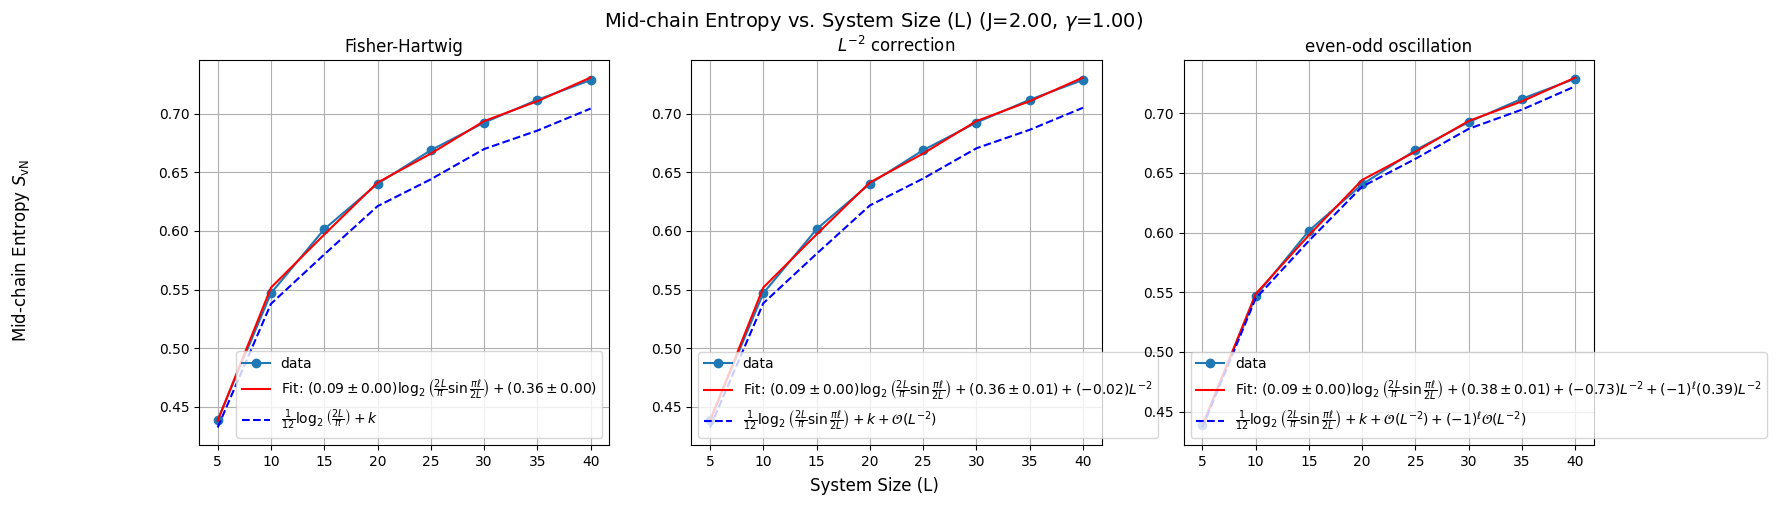

Saved entropy vs L plot: C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\plots\overall_entropy_vs_logL_J2.00_gamma1.00.png


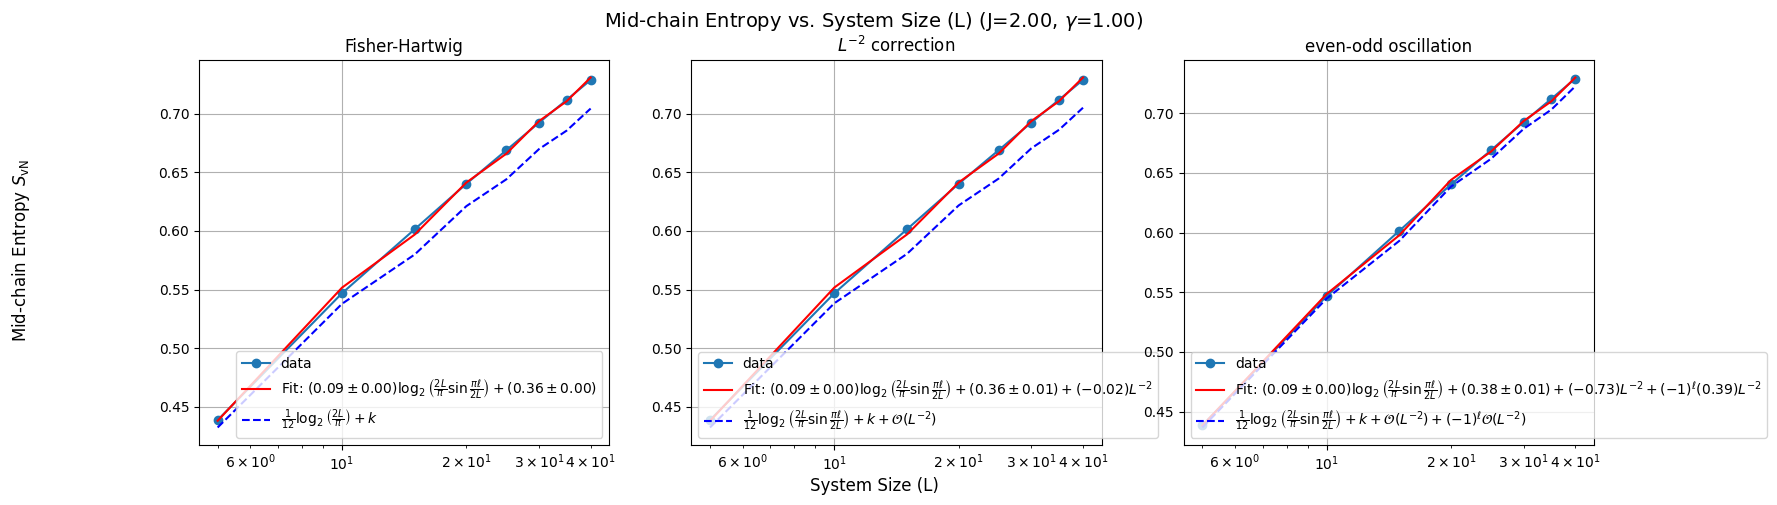

Saved J vs L heatmap: C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\plots\overall_entropy_J_vs_L_gamma1.00_heatmap.png


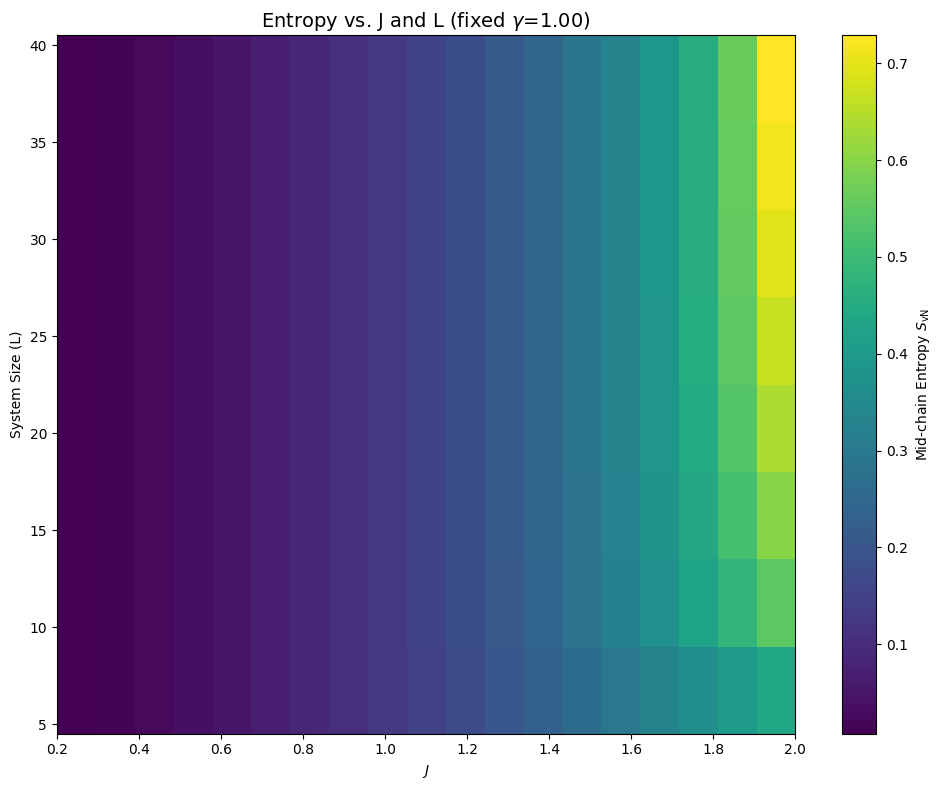

Saved gamma vs L heatmap: C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\plots\overall_entropy_gamma_vs_L_J2.00_heatmap.png


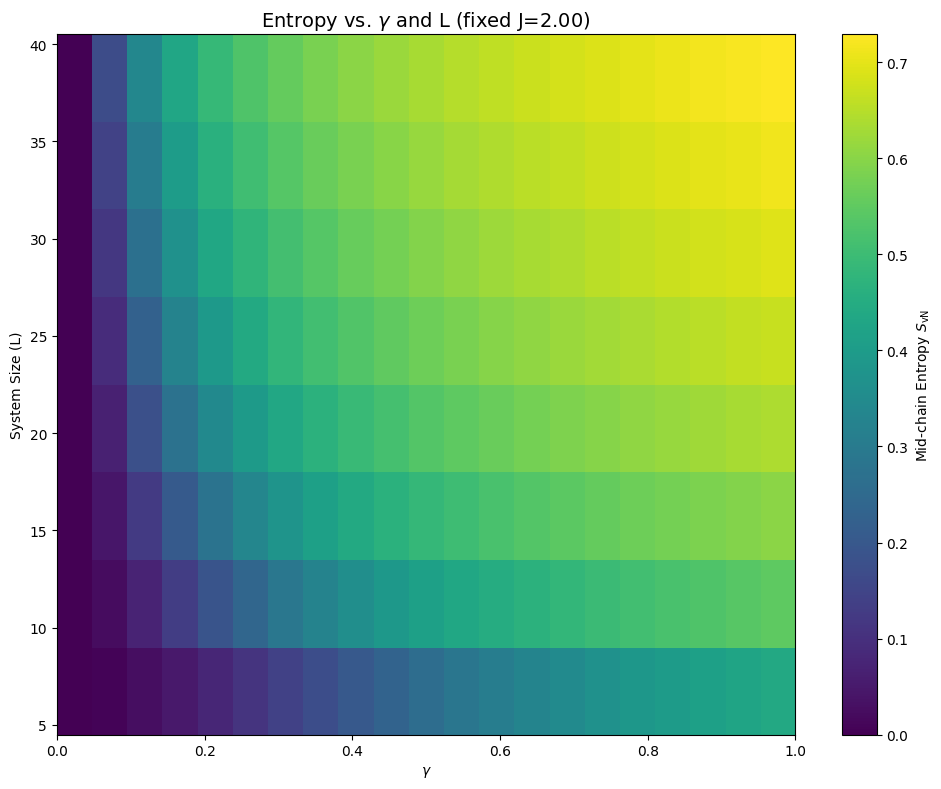

Finished processing. Plots are saved in: C:\Users\june0\OneDrive\Desktop\김준수\4-1\CLP\FinalProject\jupyter\XY\plots


In [203]:
# Main driver
current_notebook_path = os.getcwd()
data_dir_name = "data"
output_plot_dir_name = "plots"

full_data_dir_path = os.path.join(current_notebook_path, data_dir_name)
output_plot_path = os.path.join(current_notebook_path, output_plot_dir_name)
os.makedirs(output_plot_path, exist_ok=True)

extracted_entropies_for_L_line_plot = {}
all_L_data_for_J_L_heatmap = {}
all_L_data_for_gamma_L_heatmap = {}

J_vals_reference = None # To store the J_vals from the first processed file as a reference for heatmap axis
gamma_vals_reference = None # To store the gamma_vals from the first processed file

target_J_for_line_plot = 2.0
target_gamma_for_line_plot = 1.0

# Parameters for the new heatmaps
fixed_gamma_for_J_L_plot = 1.0   # The gamma value slices we'll use for the (J vs L) heatmap
fixed_J_for_gamma_L_plot = 2.0   # The J value slices we'll use for the (gamma vs L) heatmap

if not os.path.isdir(full_data_dir_path):
    print(f"Data directory not found: {full_data_dir_path}")
    pickle_files = []
else:
    pickle_files = sorted([f for f in os.listdir(full_data_dir_path) if f.endswith(".pkl")]) # Sort for consistent L processing

if not pickle_files:
    print(f"No .pkl files found in {full_data_dir_path}.")
else:
    print(f"Found {len(pickle_files)} .pkl files in {full_data_dir_path}")

    for filename in pickle_files:
        filepath = os.path.join(full_data_dir_path, filename)
        print(f"Processing {filepath}...")
        try:
            data = load_data(filepath)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

        L_val = data.get("system_size")
        current_Js = np.array(data.get("J_vals", []))
        current_gammas = np.array(data.get("gamma_vals", []))
        SvN_data = data.get("SvN") # This is the 2D matrix SvN[J_idx, gamma_idx]

        if L_val is None or not current_Js.size or not current_gammas.size or SvN_data is None:
            print(f"Essential data missing in {filename}. Skipping.")
            continue

        if J_vals_reference is None: J_vals_reference = current_Js
        if gamma_vals_reference is None: gamma_vals_reference = current_gammas

        # Basic check for consistency of J_vals and gamma_vals across files for heatmap axes
        if not np.array_equal(J_vals_reference, current_Js):
            print(f"Warning: J_vals in {filename} differ from reference. Heatmap X-axis (J) might be based on first file's J values.")
        if not np.array_equal(gamma_vals_reference, current_gammas):
             print(f"Warning: gamma_vals in {filename} differ from reference. Heatmap X-axis (gamma) might be based on first file's gamma values.")


        base_filename = os.path.splitext(filename)[0]
        # plot_phase_diagrams(data, filename_prefix=base_filename, output_dir=output_plot_path)

        if base_filename.endswith('broad'):
            continue

        # --- Data for SvN vs L line plot ---
        try:
            j_idx_line = np.argmin(np.abs(current_Js - target_J_for_line_plot))
            gamma_idx_line = np.argmin(np.abs(current_gammas - target_gamma_for_line_plot))
            extracted_entropies_for_L_line_plot[L_val] = SvN_data[j_idx_line, gamma_idx_line]
        except IndexError:
            print(f"Could not extract SvN for line plot from {filename} at J~{target_J_for_line_plot}, gamma~{target_gamma_for_line_plot}")


        # --- Data for Entropy vs J and L heatmap (fixed gamma) ---
        try:
            fixed_gamma_idx = np.argmin(np.abs(current_gammas - fixed_gamma_for_J_L_plot))
            # SvN_data is [J_idx, gamma_idx]. We need SvN vs J, so we take a slice at fixed_gamma_idx
            all_L_data_for_J_L_heatmap[L_val] = SvN_data[:, fixed_gamma_idx]
        except IndexError:
            print(f"Could not extract SvN slice for J-L heatmap from {filename} at gamma~{fixed_gamma_for_J_L_plot}")


        # --- Data for Entropy vs gamma and L heatmap (fixed J) ---
        try:
            fixed_J_idx = np.argmin(np.abs(current_Js - fixed_J_for_gamma_L_plot))
            # SvN_data is [J_idx, gamma_idx]. We need SvN vs gamma, so we take a slice at fixed_J_idx
            all_L_data_for_gamma_L_heatmap[L_val] = SvN_data[fixed_J_idx, :]
        except IndexError:
             print(f"Could not extract SvN slice for gamma-L heatmap from {filename} at J~{fixed_J_for_gamma_L_plot}")


    # --- After processing all files, generate summary plots ---
    if extracted_entropies_for_L_line_plot:
        plot_entropy_vs_L(extracted_entropies_for_L_line_plot,
                            target_J_for_line_plot,
                            target_gamma_for_line_plot,
                            output_dir=output_plot_path,
                            filename_prefix="overall_")
        plot_entropy_vs_L(extracted_entropies_for_L_line_plot,
                            target_J_for_line_plot,
                            target_gamma_for_line_plot,
                            x_log_scale=True,
                            output_dir=output_plot_path,
                            filename_prefix="overall_")
    else:
        print("No data for SvN vs L line plot.")

    # Prepare data and plot for J vs L heatmap
    if all_L_data_for_J_L_heatmap and J_vals_reference is not None:
        sorted_Ls_for_J_heatmap = sorted(all_L_data_for_J_L_heatmap.keys())
        # Create a 2D numpy array for the heatmap
        # Rows: L values, Columns: J values
        heatmap_J_L_matrix = np.array([all_L_data_for_J_L_heatmap[L_s] for L_s in sorted_Ls_for_J_heatmap if L_s in all_L_data_for_J_L_heatmap])

        if heatmap_J_L_matrix.ndim == 2 and heatmap_J_L_matrix.shape[1] == len(J_vals_reference):
             plot_entropy_J_vs_L_heatmap(heatmap_J_L_matrix, J_vals_reference, sorted_Ls_for_J_heatmap,
                                        fixed_gamma_for_J_L_plot, output_dir=output_plot_path,
                                        filename_prefix="overall_")
        else:
            print(f"Could not form consistent matrix for J vs L heatmap. Shape: {heatmap_J_L_matrix.shape}, Expected columns: {len(J_vals_reference)}")
    else:
        print("Insufficient data for SvN vs J and L heatmap.")

    # Prepare data and plot for gamma vs L heatmap
    if all_L_data_for_gamma_L_heatmap and gamma_vals_reference is not None:
        sorted_Ls_for_gamma_heatmap = sorted(all_L_data_for_gamma_L_heatmap.keys())
        # Rows: L values, Columns: gamma values
        heatmap_gamma_L_matrix = np.array([all_L_data_for_gamma_L_heatmap[L_s] for L_s in sorted_Ls_for_gamma_heatmap if L_s in all_L_data_for_gamma_L_heatmap])

        if heatmap_gamma_L_matrix.ndim == 2 and heatmap_gamma_L_matrix.shape[1] == len(gamma_vals_reference):
            plot_entropy_gamma_vs_L_heatmap(heatmap_gamma_L_matrix, gamma_vals_reference, sorted_Ls_for_gamma_heatmap,
                                            fixed_J_for_gamma_L_plot, output_dir=output_plot_path,
                                            filename_prefix="overall_")
        else:
            print(f"Could not form consistent matrix for gamma vs L heatmap. Shape: {heatmap_gamma_L_matrix.shape}, Expected columns: {len(gamma_vals_reference)}")

    else:
        print("Insufficient data for SvN vs gamma and L heatmap.")

print(f"Finished processing. Plots are saved in: {output_plot_path}")

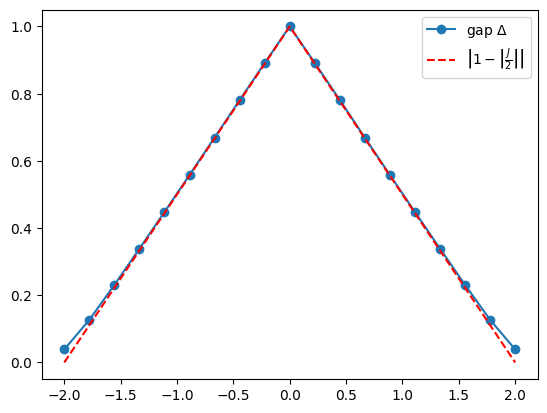

In [28]:
data = load_data('data/XY_phase_diag_L40_chi32_broad.pkl')
Js = data['J_vals']
gap = data['gap'][:, -1]
plt.plot(Js, gap, marker='o', label=r'gap $\Delta$')
plt.plot(Js, np.abs(1 - np.abs(Js/2)), 'r--', label=r'$\left| 1-\left|\frac{J}{2}\right| \right|$')
plt.legend()
plt.savefig("plots/L40_gap_slice.png", dpi=300)
plt.show()